In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import cebra.datasets  # Importing the Cebra datasets

In [2]:
class HippocampusDataset(Dataset):
    def __init__(self):
        self.data = cebra.datasets.init('rat-hippocampus-single-achilles').neural
        # Transpose data if necessary so each row is a time point and each column is a neuron
        self.data = torch.tensor(self.data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx, :]  # Get all neuron data at this time point

In [3]:
# Load the dataset
data = cebra.datasets.init('rat-hippocampus-single-achilles').neural.T

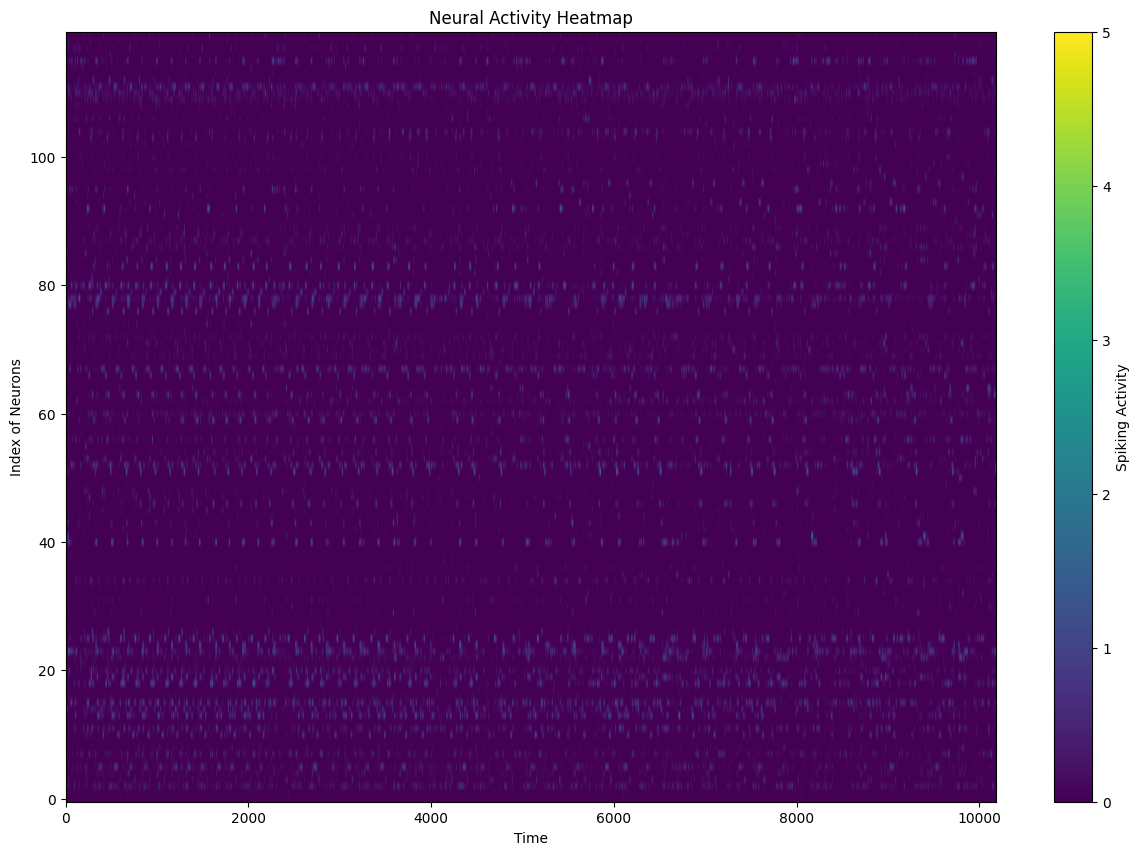

In [4]:
plt.figure(figsize=(15, 10))
plt.imshow(data, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Spiking Activity')
plt.xlabel('Time')
plt.ylabel('Index of Neurons')
plt.title('Neural Activity Heatmap')
plt.show()

In [5]:
class MaskedVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(MaskedVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # latent_dim for mean and std
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Using Sigmoid to bound the output between 0 and 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, mask):
        # Masking input
        x_masked = x * mask
        params = self.encoder(x_masked)
        mu, log_var = params[:, :latent_dim], params[:, latent_dim:]
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

def loss_function(recon_x, x, mu, log_var, mask):
    # Binary cross-entropy loss modified by mask
    BCE = (mask * nn.functional.binary_cross_entropy(recon_x, x, reduction='none')).mean()
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [6]:
dataset = HippocampusDataset()
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

/tmp/ipykernel_47647/1423841879.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data, dtype=torch.float32)


In [7]:
input_dim = dataset.data.shape[1]  # This should now represent the number of neurons
hidden_dim = 100
latent_dim = 20
model = MaskedVAE(input_dim, hidden_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        # Generate a random mask (e.g., 90% visibility)
        mask = (torch.rand_like(batch) < 0.9).float()  # Ensure mask is the same shape as batch
        recon_batch, mu, log_var = model(batch, mask)
        loss = loss_function(recon_batch, batch, mu, log_var, mask)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(dataloader)}')

Epoch 1, Loss: 0.9077834084630012
Epoch 2, Loss: 0.20479811122640967
Epoch 3, Loss: 0.16300868643447758
Epoch 4, Loss: 0.15034570349380375
Epoch 5, Loss: 0.14559800755232571
Epoch 6, Loss: 0.14354917500168085
Epoch 7, Loss: 0.14245646302588283
Epoch 8, Loss: 0.14214442810043693
Epoch 9, Loss: 0.14117278223857282
Epoch 10, Loss: 0.1409240867011249
Epoch 11, Loss: 0.14114161441102624
Epoch 12, Loss: 0.14015580331906677
Epoch 13, Loss: 0.14029786782339215
Epoch 14, Loss: 0.14070816528983415
Epoch 15, Loss: 0.1398627535905689
Epoch 16, Loss: 0.13986810678616166
Epoch 17, Loss: 0.13986917617730796
Epoch 18, Loss: 0.13951390502043068
Epoch 19, Loss: 0.139458733657375
Epoch 20, Loss: 0.1390196586959064
Epoch 21, Loss: 0.1392041718121618
Epoch 22, Loss: 0.1393623192794621
Epoch 23, Loss: 0.13942206259816886
Epoch 24, Loss: 0.13895239331759512
Epoch 25, Loss: 0.13885000818409027
Epoch 26, Loss: 0.13926067161373795
Epoch 27, Loss: 0.1393388168886304
Epoch 28, Loss: 0.13923223298043014
Epoch 29, 

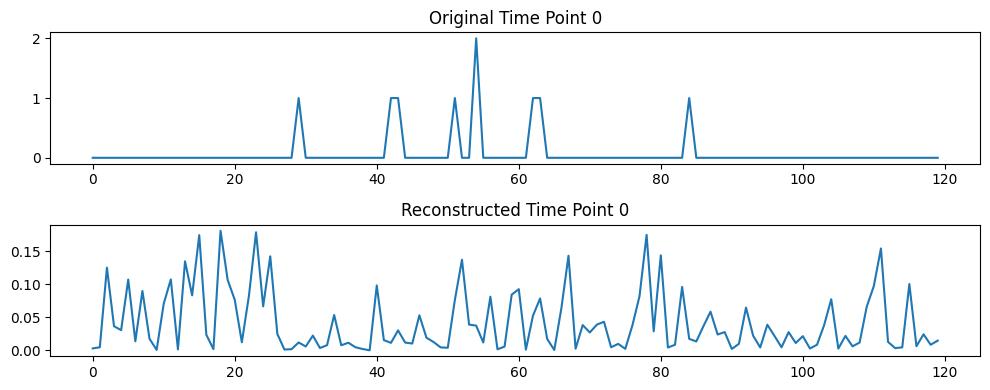

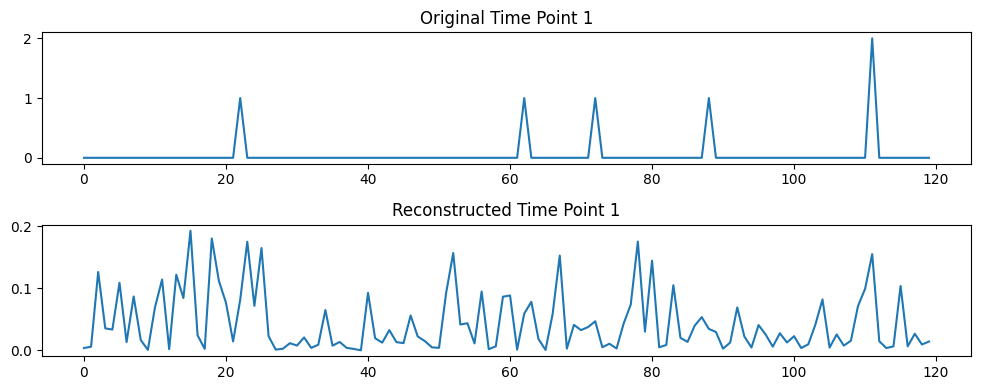

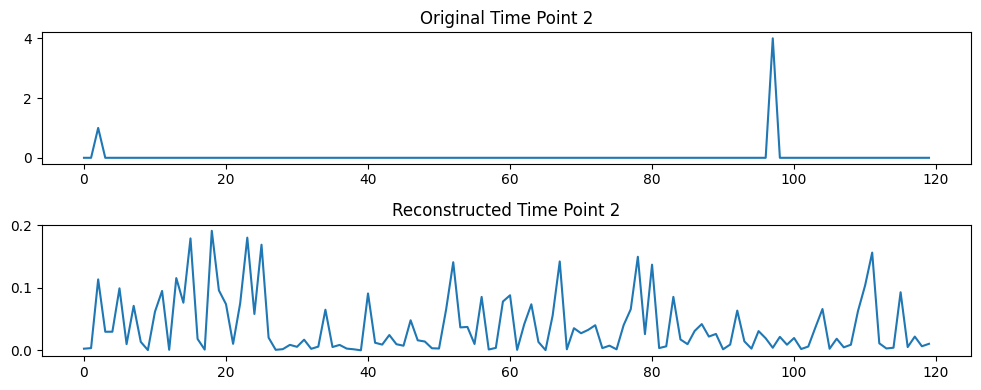

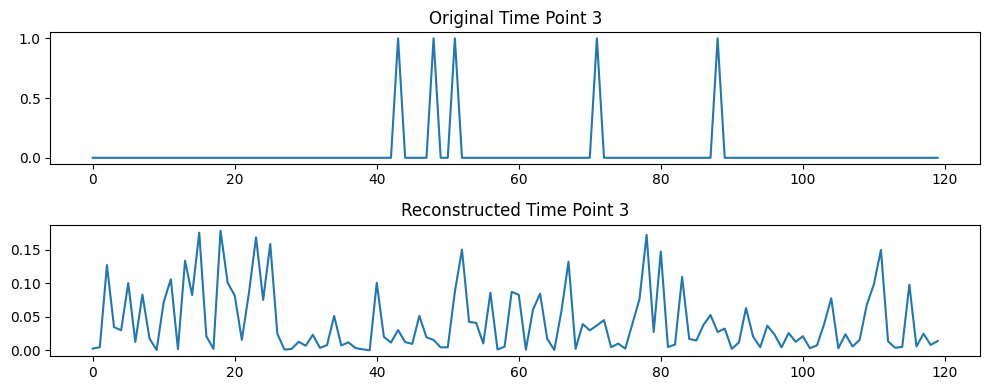

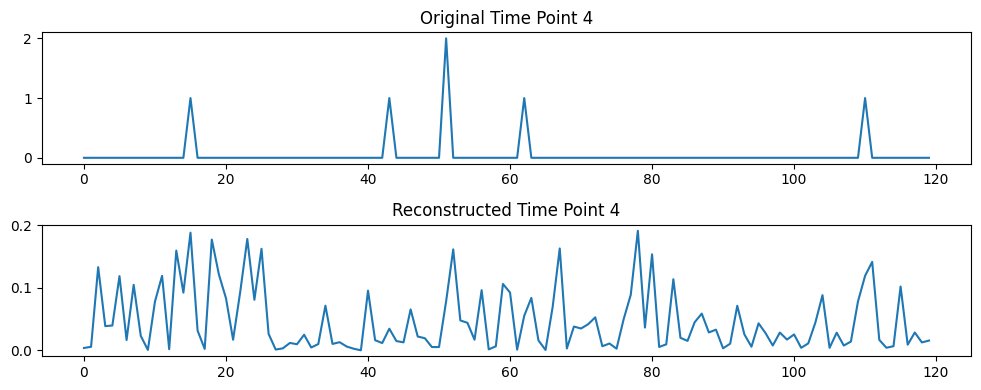

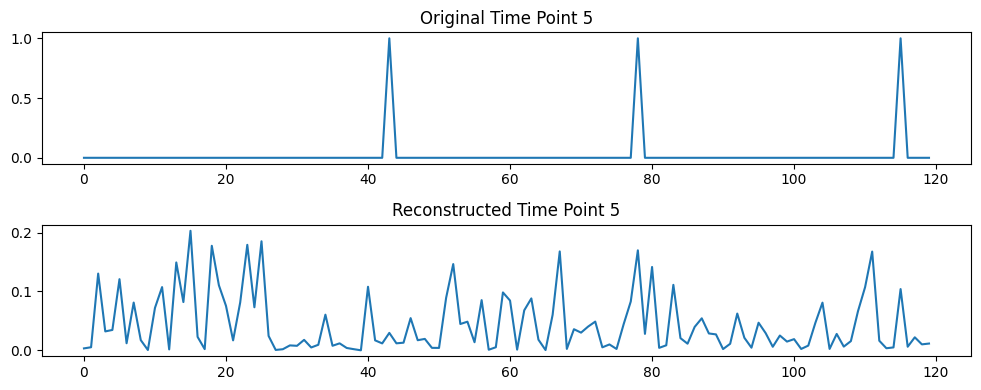

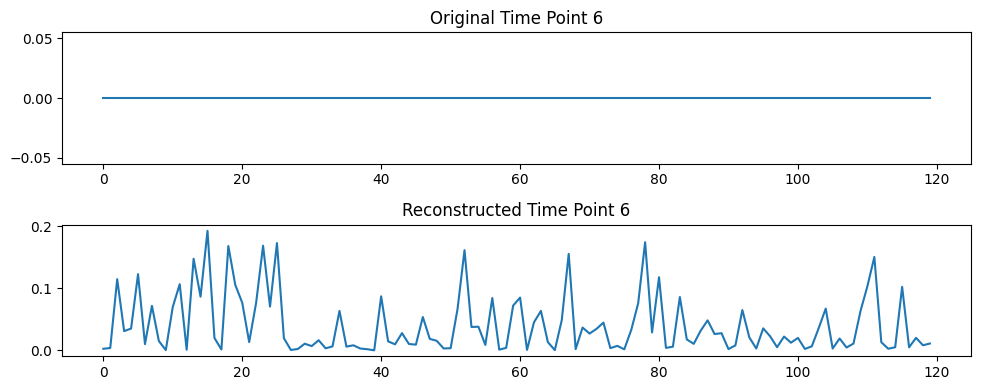

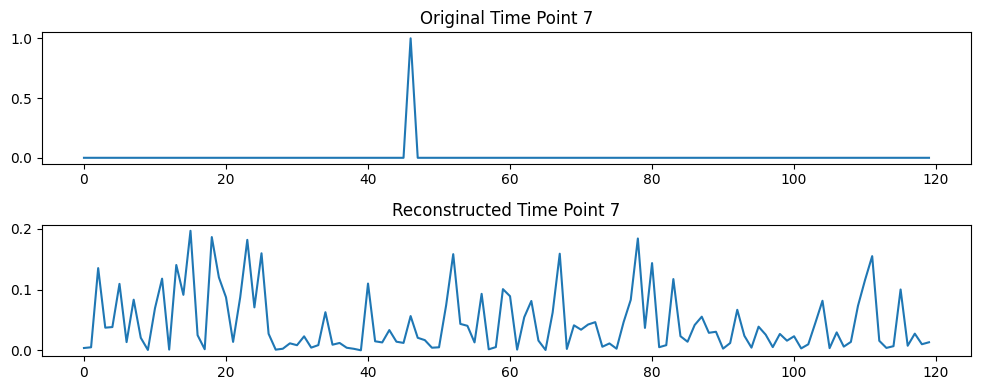

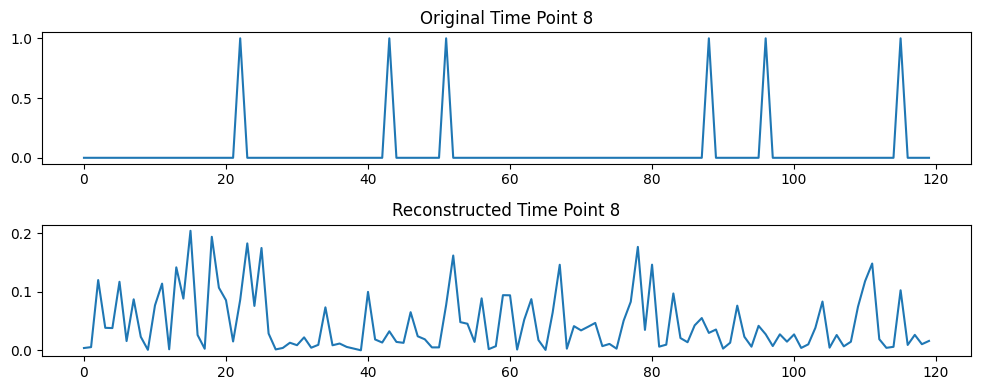

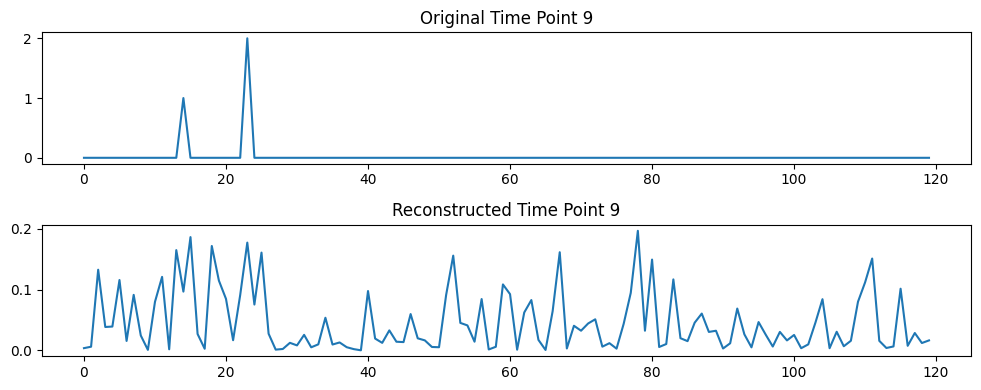

In [8]:
# Evaluate the model by plotting original and reconstructed data
model.eval()
with torch.no_grad():
    test_batch = dataset[:10]  # Take first 10 time points
    mask = torch.ones_like(test_batch)
    reconstructed, _, _ = model(test_batch, mask)
    for i in range(10):
        plt.figure(figsize=(10, 4))
        plt.subplot(2, 1, 1)
        plt.plot(test_batch[i].numpy())
        plt.title('Original Time Point ' + str(i))
        plt.subplot(2, 1, 2)
        plt.plot(reconstructed[i].numpy())
        plt.title('Reconstructed Time Point ' + str(i))
        plt.tight_layout()
        plt.show()